In [2]:
from google.colab import drive

import numpy as np
import tensorflow as tf
from tensorflow import feature_column
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, RocCurveDisplay, roc_auc_score, classification_report, confusion_matrix, roc_curve, accuracy_score
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
csv_path = "/content/drive/MyDrive/Datasets/numerical_data.csv"

In [5]:
df = pd.read_csv(csv_path)

In [26]:
# Split the data into features (X) and labels (y)
X = df.drop('HeartDisease', axis=1).values  # assuming 'target' is the label column
y = df['HeartDisease'].values

In [27]:
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [28]:
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [29]:
features = X_test.shape[-1] #total features

In [30]:
class Autoencoder(tf.keras.Model):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(encoding_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(np.prod(X_train.shape[1:]), activation='sigmoid'),
            tf.keras.layers.Reshape(X_train.shape[1:])
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(features)

In [31]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=256, validation_data=(X_val, X_val), callbacks=[early_stopping])

Epoch 1/100
891/891 [==============================] - 5s 4ms/step - loss: 0.7665 - accuracy: 0.4669 - val_loss: 0.6171 - val_accuracy: 0.5906
Epoch 2/100
891/891 [==============================] - 3s 4ms/step - loss: 0.5834 - accuracy: 0.6307 - val_loss: 0.5655 - val_accuracy: 0.6641
Epoch 3/100
891/891 [==============================] - 3s 3ms/step - loss: 0.5564 - accuracy: 0.6963 - val_loss: 0.5525 - val_accuracy: 0.7236
Epoch 4/100
891/891 [==============================] - 4s 4ms/step - loss: 0.5476 - accuracy: 0.7518 - val_loss: 0.5463 - val_accuracy: 0.7772
Epoch 5/100
891/891 [==============================] - 5s 6ms/step - loss: 0.5430 - accuracy: 0.7957 - val_loss: 0.5429 - val_accuracy: 0.8167
Epoch 6/100
891/891 [==============================] - 3s 3ms/step - loss: 0.5405 - accuracy: 0.8293 - val_loss: 0.5412 - val_accuracy: 0.8432
Epoch 7/100
891/891 [==============================] - 3s 3ms/step - loss: 0.5393 - accuracy: 0.8489 - val_loss: 0.5397 - val_accuracy: 0.8520

In [32]:
reconstructions_val = autoencoder.predict(X_val)
errors_val = np.mean(np.square(reconstructions_val - X_val), axis=1)
threshold = np.mean(errors_val) + np.std(errors_val)
print("Threshold for anomaly detection:", threshold)

2374/2374 [==============================] - 4s 2ms/step
Threshold for anomaly detection: 0.9528902725004642


**Evaluate the Model on the Test Set**

In [34]:
# Compute reconstructions for the test set
reconstructions_test = autoencoder.predict(X_test)
errors_test = np.mean(np.square(reconstructions_test - X_test), axis=1)

# Classify each sample based on the threshold
predicted_labels = [1 if e > threshold else 0 for e in errors_test]

2374/2374 [==============================] - 6s 3ms/step


In [35]:
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

         0.0       0.95      0.90      0.93     71395
         1.0       0.17      0.32      0.22      4566

    accuracy                           0.86     75961
   macro avg       0.56      0.61      0.57     75961
weighted avg       0.91      0.86      0.88     75961



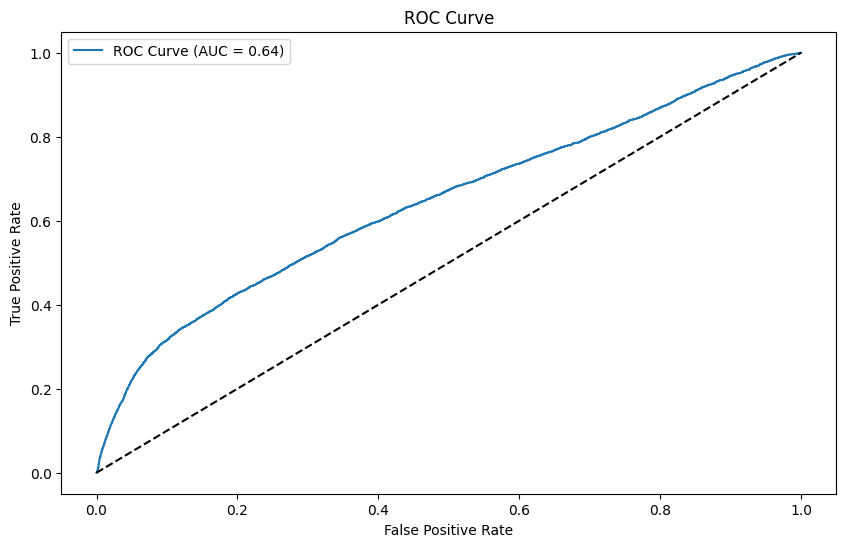

In [36]:
roc_score = roc_auc_score(y_test, errors_test)
fpr, tpr, thresholds = roc_curve(y_test, errors_test)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_score:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [37]:
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax)

    # Adjust settings
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(title)
    plt.show()

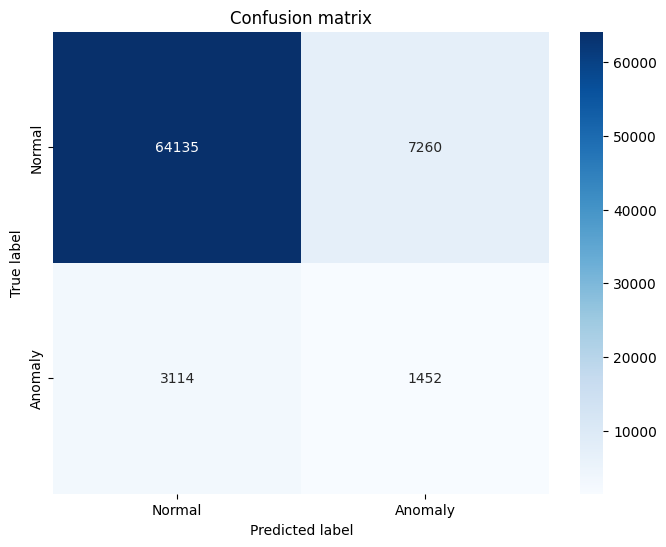

In [38]:
plot_confusion_matrix(y_test, predicted_labels, classes=['Normal', 'Anomaly'])

**Comparison between actual input and decoded response**

In [39]:
def plot_actual_vs_decoded(X_actual, X_decoded, n=10):
    """
    Plot comparison between actual input and decoded response for a few sample data points.

    Parameters:
    - X_actual: Actual data
    - X_decoded: Decoded (reconstructed) data by the autoencoder
    - n: Number of random data points to plot (default is 10)
    """
    # Randomly select n data points
    indices = np.random.choice(len(X_actual), n, replace=False)

    plt.figure(figsize=(15, 5))

    for i, idx in enumerate(indices, 1):
        plt.subplot(2, n, i)
        plt.plot(X_actual[idx], label='Actual')
        plt.plot(X_decoded[idx], '--', label='Decoded')
        plt.title(f"Sample {i}")
        if i == 1:
            plt.legend()

    plt.tight_layout()
    plt.show()


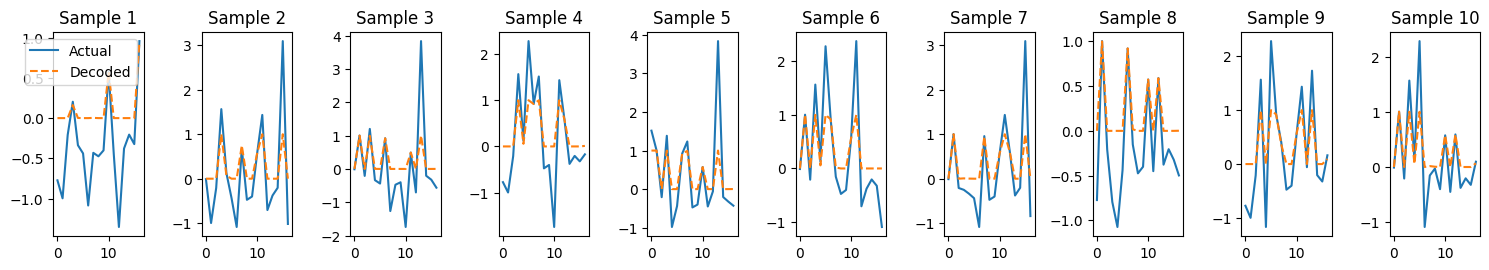

In [40]:
# Plot actual vs decoded for a few samples from the test set
plot_actual_vs_decoded(X_test, reconstructions_test)

In [43]:
def plot_comparison(X_actual, X_decoded, index=None):
    """
    Plot comparison between actual input, decoded response, and the error for a given data point.

    Parameters:
    - X_actual: Actual data
    - X_decoded: Decoded (reconstructed) data by the autoencoder
    - index: Index of the sample data point. If None, a random sample is selected.
    """

    if index is None:
        index = np.random.randint(0, len(X_actual))

    error = np.abs(X_actual[index] - X_decoded[index])

    plt.figure(figsize=(10, 5))
    plt.plot(X_actual[index], label='Input', color='blue')
    plt.plot(X_decoded[index], label='Reconstruction', color='red', linestyle='--')
    plt.plot(error, label='Error', color='pink', linestyle=':')
    plt.xlabel('Feature Column Number')
    plt.ylabel('Standardised Value')
    plt.title(f'Comparison between actual input and decoded response')
    plt.legend()
    plt.show()


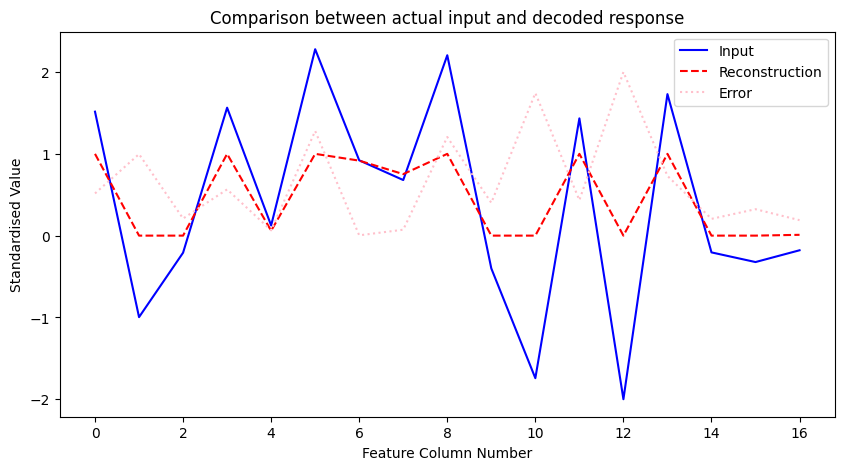

In [44]:
# Plot comparison for a random sample from the test set
plot_comparison(X_test, reconstructions_test)

**Distribution of the reconstruction error (loss) for both the training and test data**

In [46]:
# Calculate the Mean Squared Error (MSE) for training data
train_loss = np.mean(np.square(X_train - autoencoder.predict(X_train)), axis=1)

# Calculate the Mean Squared Error (MSE) for test data
test_loss = np.mean(np.square(X_test - autoencoder.predict(X_test)), axis=1)

2374/2374 [==============================] - 5s 2ms/step


In [47]:
def plot_reconstruction_error(X_train, X_test, autoencoder, threshold):
    # Calculate the Mean Squared Error (MSE) for training data
    train_loss = np.mean(np.square(X_train - autoencoder.predict(X_train)), axis=1)

    # Calculate the Mean Squared Error (MSE) for test data
    test_loss = np.mean(np.square(X_test - autoencoder.predict(X_test)), axis=1)

    # Plot for Training Data Reconstruction Error
    plt.figure(figsize=(10, 6))
    plt.hist(train_loss, bins=50, alpha=0.6, color='blue')
    plt.title('Normal Training Data Reconstruction Error Histogram')
    plt.xlabel('Train loss')
    plt.ylabel('No of examples')
    plt.show()

    # Plot for Test Data Reconstruction Error with Threshold
    plt.figure(figsize=(10, 6))
    plt.hist(test_loss, bins=50, alpha=0.6, color='blue')
    plt.axvline(threshold, color='red', linestyle='--')  # Threshold line
    plt.title('Mixed Test Data Reconstruction Error Histogram With Threshold Line')
    plt.xlabel('Test loss')
    plt.ylabel('No of examples')
    plt.show()

2374/2374 [==============================] - 5s 2ms/step


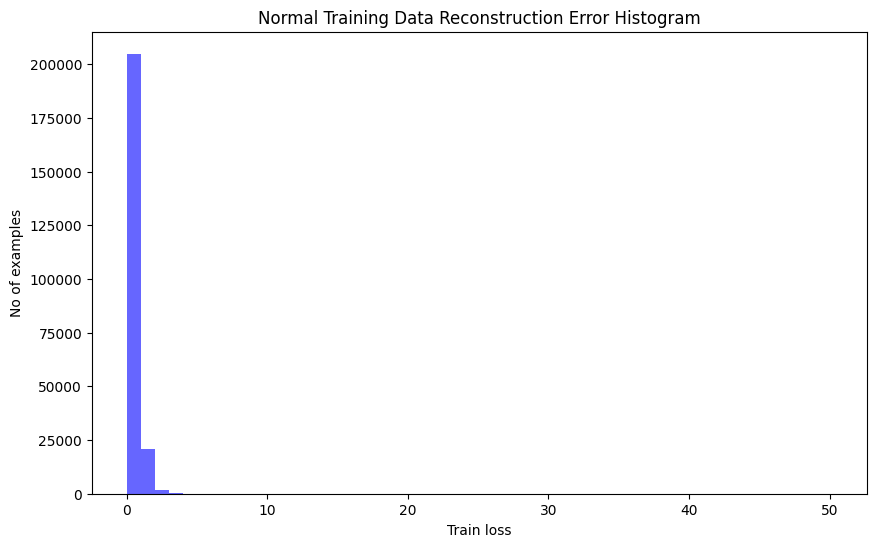

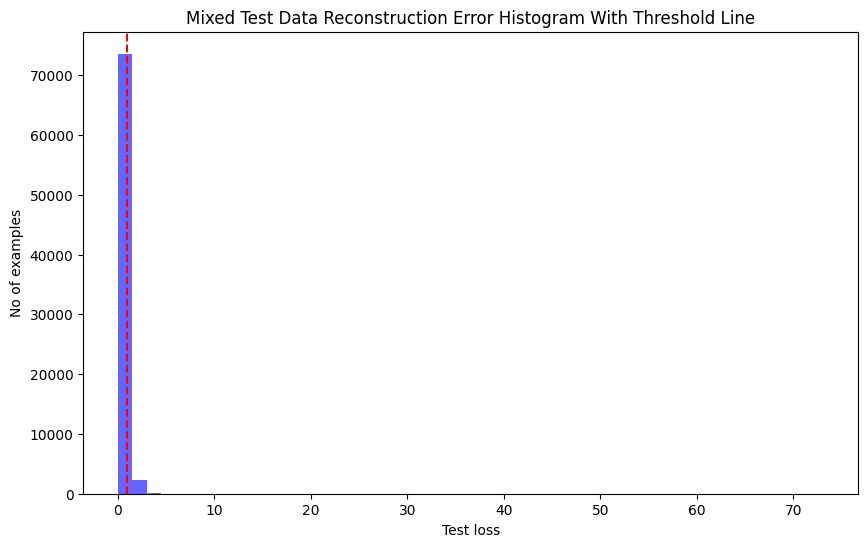

In [48]:
# Call the function
plot_reconstruction_error(X_train, X_test, autoencoder, threshold)